In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time
import math
from sklearn.datasets import make_blobs

In [2]:
def parameters_initialization(layers):
    np.random.seed(3)
    parameter = {}
    len_layers = len(layers)
    for l in range(1,len_layers):
        parameter["W"+str(l)] = np.random.randn(layers[l],layers[l-1])*np.sqrt(2/layers[l-1])
        parameter["b"+str(l)] = np.zeros((layers[l],1))
    return parameter
        
def sigmoid(Z):
    val = 1./(1. + np.exp(-Z))
    return val, (val,Z)

def relu(Z):
    val = np.maximum(0.0,Z)
    return val, (val,Z)

def sigmoid_backward(AL, Y, cache):
    Z = cache[1]
    dZ = AL - Y
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    A = cache[0]
    Z = cache[1]
    dZ = np.multiply(dA, np.int64(A > 0))
    assert (dZ.shape == Z.shape)
    return  dZ

def forward_prop_linear(A_prev, W, b):
    Z = np.dot(W,A_prev) + b
    caches = (A_prev, W, b)
    return Z, caches

def forward_prop_activation(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = relu(Z)
    caches = (linear_caches,activation_caches)
    return A , caches

def L_forward_prop(X, parameters):
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches
    
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = np.squeeze(-1./m * (np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1.-Y),np.log(1.-AL)))))
    return cost

def back_prop_linear(dZ, caches):
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = 1./m * (np.dot(dZ, A_prev.T))
    db = 1./m * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def back_prop_activation(dA, Y, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dZ  = sigmoid_backward(dA, Y, activation_cache)
        dA_prev, dW, db = back_prop_linear(dZ, linear_cache)
        
    elif activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = back_prop_linear(dZ, linear_cache)
        
    return dA_prev, dW, db

def L_back_prob(Y, AL, caches):
    
    grads = {}
    m = Y.shape[1]
    L = len(caches)
    Y = Y.reshape(AL.shape)
    
    current_cache = caches[L-1]
    d_A_prev_temp, dW_temp, db_temp = back_prop_activation(AL, Y, current_cache, activation = "sigmoid")
    grads["dA"+ str(L-1)] = d_A_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for i in  reversed(range(L-1)):
        current_cache = caches[i]
        d_A_prev_temp, dW_temp, db_temp = back_prop_activation(grads["dA"+ str(i+1)], Y, current_cache, activation = "relu")
        grads["dA"+ str(i)] = d_A_prev_temp
        grads["dW" + str(i+1)] = dW_temp
        grads["db" + str(i+1)] = db_temp
        
    return grads

def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(params)//2
    
    for l in range(1, L+1):
        parameters["W"+str(l)] = params["W"+str(l)] - learning_rate*grads["dW"+str(l)]
        parameters["b"+str(l)] = params["b"+str(l)] - learning_rate*grads["db"+str(l)]
    
    return parameters

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
def accuracy_score(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.round(np.squeeze(y_pred)).astype("int64")
    m = len(y_pred)
    correct = len(y_pred[y_pred == y_true])
    accuracy = correct/m
    return accuracy

def L_layer_model(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []          # keep track of cost
    train_acc = []
    test_acc = []
    # Parameters initialization.
    parameters = parameters_initialization(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_forward_prop(X_train, parameters)
        
        # Compute cost.
        cost = compute_cost(AL,Y_train)
        costs.append(cost)
    
        # Backward propagation.
        grads = L_back_prob(Y_train,AL,caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Accuracy Checking.
        
        y_pred_train, caches_train = L_forward_prop(X_train, parameters)
        y_pred_test, caches_test = L_forward_prop(X_test, parameters)
        
        train_acc.append(accuracy_score(Y_train,y_pred_train))
        test_acc.append(accuracy_score(Y_test,y_pred_test))
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    return parameters, grads, costs, train_acc, test_acc
        

In [19]:
def compute_cost_with_regularization(AL, Y, parameters,  lambd):
    
    m = Y.shape[1]
    n_params = len(parameters) // 2
    cost_original = np.squeeze(-1./m * (np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1.-Y),np.log(1.-AL)))))
    L2_sum = 0
    
    for l in range(1, n_params + 1):
        L2_sum += np.sum(np.square(parameters["W" + str(l)]))
        
    L2_cost = (lambd/(2.*m))*L2_sum
    
    cost = cost_original + L2_cost
    return cost

def back_prop_linear_with_regularization(dZ, caches, lambd):
    
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = (1./m) * (np.dot(dZ, A_prev.T)) + (lambd/m)*W 
    db = (1./m) * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def back_prop_activation_with_regularization(dA, Y, cache, lambd, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dZ  = sigmoid_backward(dA, Y, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    elif activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    return dA_prev, dW, db

def L_back_prob_with_regularization(Y, AL, lambd, caches):
    
    grads = {}
    m = Y.shape[1]
    L = len(caches)
    Y = Y.reshape(AL.shape)

    current_cache = caches[L-1]
    d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization(AL, Y, current_cache, lambd, activation = "sigmoid")
    grads["dA"+ str(L-1)] = d_A_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for i in  reversed(range(L-1)):
        current_cache = caches[i]
        d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization(grads["dA"+ str(i+1)],Y, current_cache, lambd, activation = "relu")
        grads["dA"+ str(i)] = d_A_prev_temp
        grads["dW" + str(i+1)] = dW_temp
        grads["db" + str(i+1)] = db_temp
        
    return grads

def L_layer_model_with_regularization(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.0075, lambd = 0, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []          # keep track of cost
    train_acc = []
    test_acc = []
    # Parameters initialization.
    parameters = parameters_initialization(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_forward_prop(X_train, parameters)
        
        # Compute cost.
        cost = compute_cost_with_regularization(AL, Y_train, parameters,  lambd)
        costs.append(cost)
    
        # Backward propagation.
        grads = L_back_prob_with_regularization(Y_train, AL, lambd, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Accuracy Checking.
        
        y_pred_train, caches_train = L_forward_prop(X_train, parameters)
        y_pred_test, caches_test = L_forward_prop(X_test, parameters)
        
        train_acc.append(accuracy_score(Y_train,y_pred_train))
        test_acc.append(accuracy_score(Y_test,y_pred_test))
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    return parameters, grads, costs, train_acc, test_acc
        

## With Regularization and ADAM Optimizer.

In [4]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
    
        v["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads["dW" + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads["db" + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1-beta1**t)
        
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*(grads["dW" + str(l)])**2
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*(grads["db" + str(l)])**2

        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-beta2**t)
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1-beta2**t)

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*(v_corrected["dW" + str(l)]/(np.sqrt(s_corrected["dW" + str(l)])+epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*(v_corrected["db" + str(l)]/(np.sqrt(s_corrected["db" + str(l)])+epsilon))

    return parameters, v, s, v_corrected, s_corrected

def L_layer_model_with_regularization_adam(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.0075, lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []          # keep track of cost
    train_acc = []
    test_acc = []
    # Parameters initialization.
    parameters = parameters_initialization(layers_dims)
    v, s = initialize_adam(parameters)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_forward_prop(X_train, parameters)
        
        # Compute cost.
        cost = compute_cost_with_regularization(AL, Y_train, parameters,  lambd)
        costs.append(cost)
    
        # Backward propagation.
        grads = L_back_prob_with_regularization(Y_train, AL, lambd, caches)
 
        # Update parameters.
        parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, i+1, learning_rate , beta1, beta2, epsilon)
        
        # Accuracy Checking.
        
        y_pred_train, caches_train = L_forward_prop(X_train, parameters)
        y_pred_test, caches_test = L_forward_prop(X_test, parameters)
        
        train_acc.append(accuracy_score(Y_train,y_pred_train))
        test_acc.append(accuracy_score(Y_test,y_pred_test))
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    return parameters, grads, costs, train_acc, test_acc
        

## With Mini Batch

In [50]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:,inc*k:inc*(k+1)]
        mini_batch_Y = shuffled_Y[:,inc*k:inc*(k+1)].reshape((1,inc))

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:,inc*(k+1):(inc*(k+1) + (m-inc*math.floor(m/inc)))]
        mini_batch_Y = shuffled_Y[:,inc*(k+1):(inc*(k+1) + (m-inc*math.floor(m/inc)))].reshape((1,(m-inc*math.floor(m/inc))))

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

def model_mini_batches(X_train, Y_train, layers_dims, learning_rate = 0.0075, lambd = 0, beta1 =0.90, beta2 = 0.99, epsilon = 1e-8, num_iterations = 3000, mini_batch_size = 64, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    seed = 3
    costs = [] 
    t = 0
    m = X_train.shape[1]
    # Parameters initialization.
    parameters = parameters_initialization(layers_dims)
    v, s = initialize_adam(parameters)

    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            
            (minibatch_X, minibatch_Y) = minibatch

            AL, caches = L_forward_prop( minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost_with_regularization(AL, minibatch_Y, parameters,  lambd)

            # Backward propagation
            grads = L_back_prob_with_regularization(minibatch_Y, AL, lambd, caches)

            # Update parameters
            t = t + 1 # Adam counter
            parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
            
        cost_avg = cost_total / m
        costs.append(cost_avg)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost_avg)))
    
    return parameters, grads, costs
        

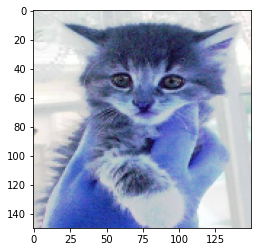

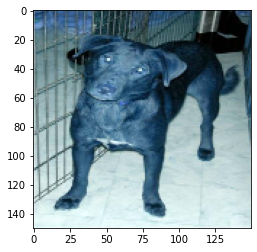

In [5]:
img_cat = cv2.resize(cv2.imread("CatsvsDogs/Train/Cats/cat.100.jpg"),(150,150))
img_dog = cv2.resize(cv2.imread("CatsvsDogs/Train/Dogs/dog.1.jpg"),(150,150))
plt.imshow(img_cat)
plt.show()
plt.imshow(img_dog)
plt.show()

In [37]:
list_img_cats_train = glob.glob("CatsvsDogs/Train/Cats/*.jpg")[:250]
list_img_dogs_train = glob.glob("CatsvsDogs/Train/Dogs/*.jpg")[:250]
list_img_cats_test = glob.glob("CatsvsDogs/Test/Cats/*.jpg")
list_img_dogs_test = glob.glob("CatsvsDogs/Test/Dogs/*.jpg")

print("Training data shape :")
print(len(list_img_cats_train))
print(len(list_img_dogs_train))
print("Testing data shape :")
print(len(list_img_cats_test))
print(len(list_img_dogs_test))

Training data shape :
250
250
Testing data shape :
25
25


In [38]:
img_x_cats_train = np.array([cv2.resize(cv2.imread(cat),(200,200)) for cat in list_img_cats_train])
img_x_dogs_train = np.array([cv2.resize(cv2.imread(dog),(200,200)) for dog in list_img_dogs_train])
img_y_cats_train = np.ones((1,len(list_img_cats_train)), dtype='int64')
img_y_dogs_train = np.zeros((1,len(list_img_dogs_train)), dtype = 'int64')

img_x_cats_test = np.array([cv2.resize(cv2.imread(cat),(200,200)) for cat in list_img_cats_test])
img_x_dogs_test = np.array([cv2.resize(cv2.imread(dog),(200,200)) for dog in list_img_dogs_test])
img_y_cats_test = np.ones((1,len(list_img_cats_test)), dtype='int64')
img_y_dogs_test= np.zeros((1,len(list_img_dogs_test)), dtype = 'int64')

In [39]:
training_x_concatenated = np.concatenate((img_x_cats_train,img_x_dogs_train), axis = 0)
test_x_concatenated = np.concatenate((img_x_cats_test,img_x_dogs_test), axis = 0)
training_y_concatenated = np.concatenate((img_y_cats_train,img_y_dogs_train), axis = 1)
test_y_concatenated = np.concatenate((img_y_cats_test,img_y_dogs_test), axis = 1)

In [40]:
print("Training data shape :")
print("Train X shape :")
print(training_x_concatenated.shape)
print("Train Y shape :")
print(training_y_concatenated.shape)
print("="*50)
print("Testing data shape :")
print("Test X shape :")
print(test_x_concatenated.shape)
print("Test Y shape :")
print(test_y_concatenated.shape)

Training data shape :
Train X shape :
(500, 200, 200, 3)
Train Y shape :
(1, 500)
Testing data shape :
Test X shape :
(50, 200, 200, 3)
Test Y shape :
(1, 50)


In [41]:
training_x_flatten = training_x_concatenated.reshape(training_x_concatenated.shape[0],-1).T
test_x_flatten = test_x_concatenated.reshape(test_x_concatenated.shape[0],-1).T
print("Training data shape :")
print("Train X shape :")
print(training_x_flatten.shape)
print("Train Y shape :")
print(test_x_flatten.shape)

Training data shape :
Train X shape :
(120000, 500)
Train Y shape :
(120000, 50)


In [42]:
train_x = training_x_flatten/225
train_y = training_y_concatenated.copy()
test_x = test_x_flatten/225
test_y = test_y_concatenated.copy()

In [43]:
print("Training data shape :")
print(f"X shape = {train_x.shape}")
print(f"Y shape = {train_y.shape}")
print("Testing data shape :")
print(f"X shape = {test_x.shape}")
print(f"Y shape = {test_y.shape}")

Training data shape :
X shape = (120000, 500)
Y shape = (1, 500)
Testing data shape :
X shape = (120000, 50)
Y shape = (1, 50)


In [45]:
layers_dims = [120000,750,500,250,100,50,25,10,5,1] # 10 layers
parameters, gradients, cost, train_acc, test_acc = L_layer_model_with_regularization_adam(train_x, train_y, test_x, test_y, layers_dims, learning_rate = 0.00001, 
                                                                                          lambd = 5, beta1 =0.90, beta2 = 0.99, epsilon = 1e-8, num_iterations = 5000, print_cost=True)

Cost after iteration 0: 17.811444382216404
Cost after iteration 100: 16.434826321924746
Cost after iteration 200: 15.582393094368664
Cost after iteration 300: 14.787316171751032
Cost after iteration 400: 13.972048078206484
Cost after iteration 500: 13.116444278080252
Cost after iteration 600: 12.22970355378561
Cost after iteration 700: 11.338515150675107
Cost after iteration 800: 11.489973714246009
Cost after iteration 900: 10.855741715267213
Cost after iteration 1000: 10.35265427680077
Cost after iteration 1100: 9.928561945743342
Cost after iteration 1200: 9.51940820399788
Cost after iteration 1300: 9.091034887671858
Cost after iteration 1400: 8.634238984822286
Cost after iteration 1500: 8.171624317680028
Cost after iteration 1600: 7.732152660262542
Cost after iteration 1700: 7.499634033394135
Cost after iteration 1800: 7.2833154185106
Cost after iteration 1900: 7.069970050688469
Cost after iteration 2000: 6.85316266477477
Cost after iteration 2100: 6.629201545733759
Cost after iterat

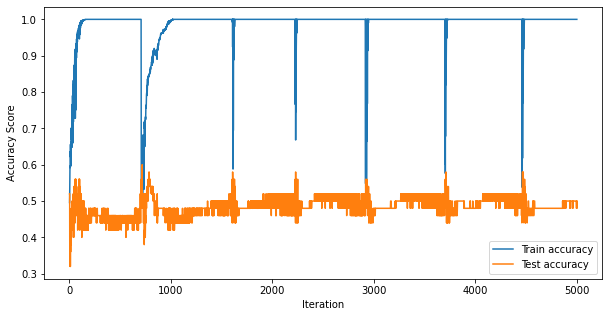

In [46]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(train_acc)+1), train_acc, label = 'Train accuracy')
ax.plot(np.arange(1,len(test_acc)+1), test_acc, label = 'Test accuracy')
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy Score")
ax.legend()
plt.show()

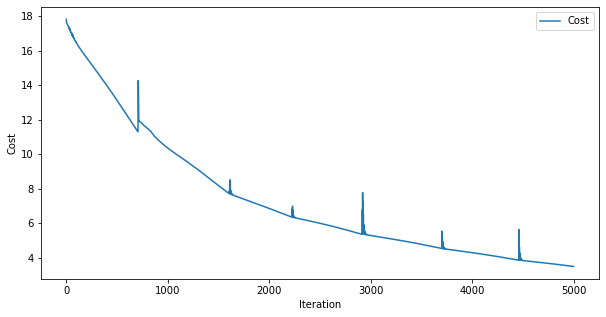

In [49]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(cost)+1), cost, label = 'Cost')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost")
ax.legend()
plt.show()